In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('../content/drive', force_remount=True)

Mounted at ../content/drive


# 바꿔야할 부분
※ 경로

In [ ]:
cd ../content/drive/My Drive/졸업작품/KWS

/content/drive/My Drive/졸업작품/KWS


In [ ]:
''' import libraries '''

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms  # 1 batch = (1, 784)
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

from sklearn.metrics import f1_score

import os

In [ ]:
# torch.device
print("is there cuda? :",  torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

is there cuda? : True
cuda:0


In [ ]:
n_mfcc = 24
Tx = 1723

In [ ]:
## Multi-label GRU model 구현
# GRU layer


class KWS_2GRU(nn.Module):
    def __init__(self, p=0.0):
        super(KWS_2GRU, self).__init__()
        self.num_feature = n_mfcc
        self.hidden_size = 128
        self.conv = nn.Conv1d(in_channels=n_mfcc, out_channels=self.num_feature,
                                kernel_size=3, stride=1, padding=1) # Tx = 1723 = Ty 유지
        self.bn_num_feature = nn.BatchNorm1d(self.num_feature) # [N,C,L], what is channel?
        self.bn_Tx = nn.BatchNorm1d(Tx)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=p) 

        self.GRU1 = nn.GRU(self.num_feature, self.hidden_size,
                            num_layers=1, batch_first=True)
        self.GRU2 = nn.GRU(self.hidden_size, self.hidden_size,
                            num_layers=1, batch_first=True)
        self.linear = nn.Linear(Tx*self.hidden_size, Tx)

        '''    def myGRU(self, input_size, hidden_size, x):
        # class 내부 method는 self, 인자 필수!
         # GRU
        #     input (batch, seq_len, input_size) via batch_first
        #     hidden (num_layers * num_directions, batch, hidden_size)
        #     output (batch, seq_len, num_directions * hidden_size)

        batch_size = x.shape[0]
        #hidden = Variable(torch.zeros(1,batch_size, hidden_size)).to(device)

        # 내부에서 연산을해버리니깐, nn.GRU layer를 gpu에 올려야하네
        output, hidden = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                    num_layers=1, batch_first=True).to(device)(x) #, hidden)
        return nn.Sequential(
                    self.dropout, self.bn_Tx         
        )(output)'''

    def forward(self, x):
        # method 1 : conv1d
      
        x = torch.transpose(x, 1, 2)  # [batch_size, Tx, n_mfcc] -> [batch_size, n_mfcc, Tx]
        x = self.conv(x) # -> [batch_size, self.num_feature, Tx]
        output = nn.Sequential(
            self.bn_num_feature, self.relu, self.dropout,
        )(x)
        output = torch.transpose(output, 1, 2)  # -> [b, Tx, self.num_feature]
 
        '''
        # moethod 2 : without conv1d
        #output = x 

        #output = self.myGRU(self.num_feature, self.hidden_size, output)
        #output = self.myGRU(self.hidden_size, 1, output)
        #print(output.shape)'''
        
        output, hidden = self.GRU1(output)
        output = nn.Sequential(self.dropout, self.bn_Tx)(output)
        output, hidden = self.GRU2(output, hidden)
        output = nn.Sequential(self.dropout, self.bn_Tx, self.dropout)(output)
        output = output.view(-1, Tx*self.hidden_size)
        #print(output.shape)
        output = self.linear(output)
        # #output = nn.linear()

        return output #torch.sigmoid(output)

In [ ]:
'''hyper parameter'''
lr = 0.001
drop_prob = 0.2
weight_decay = 1e-3
model = KWS_2GRU(p=drop_prob).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr) #, weight_decay=weight_decay)
#summary(model, input_size=(Tx, n_mfcc))
#print("summary에 GRU 안 나오네..")

In [ ]:
batch_size = 10
## data load
X_train = np.load("./KWS_data/XY_train/train0_X.npy")  #(100, 1723, 24)
Y_train = np.load("./KWS_data/XY_train/train0_Y.npy") #(100, 1723, 1)
# X_train = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_train)) 
#=> 왜 이미 되있지?

### sigmoid -> prediction -> BCE loss

train 0 ?.npy file load 완료
epoch: 0	data num: 100	Loss: 4.714	f1_score: 0.103
train 1 ?.npy file load 완료
epoch: 0	data num: 200	Loss: 3.939	f1_score: 0.057
train 2 ?.npy file load 완료
epoch: 0	data num: 300	Loss: 3.869	f1_score: 0.085
train 3 ?.npy file load 완료
epoch: 0	data num: 400	Loss: 4.537	f1_score: 0.078
train 4 ?.npy file load 완료
epoch: 0	data num: 500	Loss: 3.593	f1_score: 0.101
train 5 ?.npy file load 완료
epoch: 0	data num: 600	Loss: 2.276	f1_score: 0.231
train 6 ?.npy file load 완료
epoch: 0	data num: 700	Loss: 3.045	f1_score: 0.111
train 7 ?.npy file load 완료
epoch: 0	data num: 800	Loss: 2.106	f1_score: 0.191
train 8 ?.npy file load 완료
epoch: 0	data num: 900	Loss: 2.082	f1_score: 0.172
train 9 ?.npy file load 완료
epoch: 0	data num: 1000	Loss: 2.868	f1_score: 0.164
train 10 ?.npy file load 완료
epoch: 0	data num: 1100	Loss: 2.095	f1_score: 0.253
train 11 ?.npy file load 완료
epoch: 0	data num: 1200	Loss: 1.440	f1_score: 0.309
train 12 ?.npy file load 완료
epoch: 0	data num: 1300	Loss: 1

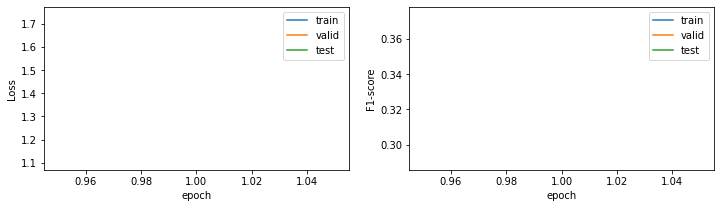

train 0 ?.npy file load 완료
epoch: 1	data num: 100	Loss: 0.695	f1_score: 0.515
train 1 ?.npy file load 완료
epoch: 1	data num: 200	Loss: 0.702	f1_score: 0.509
train 2 ?.npy file load 완료
epoch: 1	data num: 300	Loss: 0.772	f1_score: 0.459
train 3 ?.npy file load 완료
epoch: 1	data num: 400	Loss: 0.788	f1_score: 0.390
train 4 ?.npy file load 완료
epoch: 1	data num: 500	Loss: 0.706	f1_score: 0.480
train 5 ?.npy file load 완료
epoch: 1	data num: 600	Loss: 0.819	f1_score: 0.394
train 6 ?.npy file load 완료
epoch: 1	data num: 700	Loss: 1.010	f1_score: 0.411
train 7 ?.npy file load 완료
epoch: 1	data num: 800	Loss: 0.816	f1_score: 0.488
train 8 ?.npy file load 완료
epoch: 1	data num: 900	Loss: 0.457	f1_score: 0.627
train 9 ?.npy file load 완료
epoch: 1	data num: 1000	Loss: 0.690	f1_score: 0.440
train 10 ?.npy file load 완료
epoch: 1	data num: 1100	Loss: 1.047	f1_score: 0.436
train 11 ?.npy file load 완료
epoch: 1	data num: 1200	Loss: 0.714	f1_score: 0.415
train 12 ?.npy file load 완료
epoch: 1	data num: 1300	Loss: 0

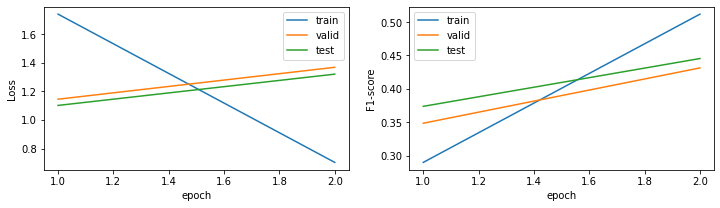

train 0 ?.npy file load 완료
epoch: 2	data num: 100	Loss: 0.580	f1_score: 0.643
train 1 ?.npy file load 완료
epoch: 2	data num: 200	Loss: 0.512	f1_score: 0.658
train 2 ?.npy file load 완료
epoch: 2	data num: 300	Loss: 0.401	f1_score: 0.651
train 3 ?.npy file load 완료
epoch: 2	data num: 400	Loss: 0.730	f1_score: 0.546
train 4 ?.npy file load 완료
epoch: 2	data num: 500	Loss: 0.468	f1_score: 0.659
train 5 ?.npy file load 완료
epoch: 2	data num: 600	Loss: 0.537	f1_score: 0.644
train 6 ?.npy file load 완료
epoch: 2	data num: 700	Loss: 0.670	f1_score: 0.498
train 7 ?.npy file load 완료
epoch: 2	data num: 800	Loss: 0.676	f1_score: 0.562
train 8 ?.npy file load 완료
epoch: 2	data num: 900	Loss: 0.572	f1_score: 0.577
train 9 ?.npy file load 완료
epoch: 2	data num: 1000	Loss: 0.571	f1_score: 0.599
train 10 ?.npy file load 완료
epoch: 2	data num: 1100	Loss: 0.904	f1_score: 0.498
train 11 ?.npy file load 완료
epoch: 2	data num: 1200	Loss: 0.684	f1_score: 0.517
train 12 ?.npy file load 완료
epoch: 2	data num: 1300	Loss: 0

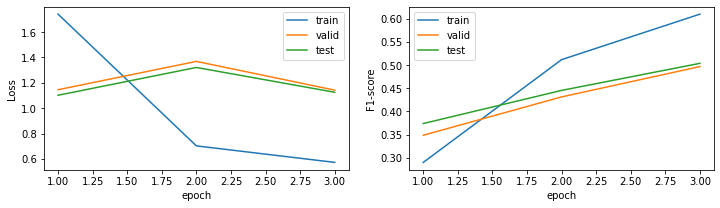

train 0 ?.npy file load 완료
epoch: 3	data num: 100	Loss: 0.274	f1_score: 0.756
train 1 ?.npy file load 완료
epoch: 3	data num: 200	Loss: 0.328	f1_score: 0.735
train 2 ?.npy file load 완료
epoch: 3	data num: 300	Loss: 0.397	f1_score: 0.648
train 3 ?.npy file load 완료
epoch: 3	data num: 400	Loss: 0.635	f1_score: 0.555
train 4 ?.npy file load 완료
epoch: 3	data num: 500	Loss: 0.329	f1_score: 0.775
train 5 ?.npy file load 완료
epoch: 3	data num: 600	Loss: 0.568	f1_score: 0.663
train 6 ?.npy file load 완료
epoch: 3	data num: 700	Loss: 0.642	f1_score: 0.476
train 7 ?.npy file load 완료
epoch: 3	data num: 800	Loss: 0.337	f1_score: 0.746
train 8 ?.npy file load 완료
epoch: 3	data num: 900	Loss: 0.354	f1_score: 0.705
train 9 ?.npy file load 완료
epoch: 3	data num: 1000	Loss: 0.315	f1_score: 0.691
train 10 ?.npy file load 완료
epoch: 3	data num: 1100	Loss: 0.653	f1_score: 0.527
train 11 ?.npy file load 완료
epoch: 3	data num: 1200	Loss: 0.518	f1_score: 0.582
train 12 ?.npy file load 완료
epoch: 3	data num: 1300	Loss: 0

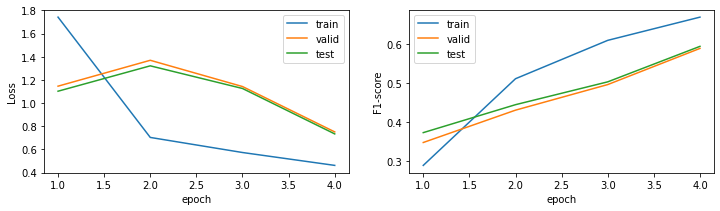

train 0 ?.npy file load 완료
epoch: 4	data num: 100	Loss: 0.274	f1_score: 0.787
train 1 ?.npy file load 완료
epoch: 4	data num: 200	Loss: 0.222	f1_score: 0.809
train 2 ?.npy file load 완료
epoch: 4	data num: 300	Loss: 0.256	f1_score: 0.757
train 3 ?.npy file load 완료
epoch: 4	data num: 400	Loss: 0.396	f1_score: 0.649
train 4 ?.npy file load 완료
epoch: 4	data num: 500	Loss: 0.268	f1_score: 0.734
train 5 ?.npy file load 완료
epoch: 4	data num: 600	Loss: 0.487	f1_score: 0.717
train 6 ?.npy file load 완료
epoch: 4	data num: 700	Loss: 0.375	f1_score: 0.631
train 7 ?.npy file load 완료
epoch: 4	data num: 800	Loss: 0.268	f1_score: 0.775
train 8 ?.npy file load 완료
epoch: 4	data num: 900	Loss: 0.228	f1_score: 0.791
train 9 ?.npy file load 완료
epoch: 4	data num: 1000	Loss: 0.391	f1_score: 0.711
train 10 ?.npy file load 완료
epoch: 4	data num: 1100	Loss: 0.471	f1_score: 0.582
train 11 ?.npy file load 완료
epoch: 4	data num: 1200	Loss: 0.354	f1_score: 0.688
train 12 ?.npy file load 완료
epoch: 4	data num: 1300	Loss: 0

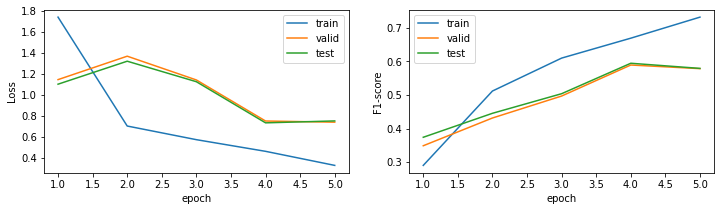

train 0 ?.npy file load 완료
epoch: 5	data num: 100	Loss: 0.398	f1_score: 0.767
train 1 ?.npy file load 완료
epoch: 5	data num: 200	Loss: 0.210	f1_score: 0.853
train 2 ?.npy file load 완료
epoch: 5	data num: 300	Loss: 0.186	f1_score: 0.825
train 3 ?.npy file load 완료
epoch: 5	data num: 400	Loss: 0.459	f1_score: 0.663
train 4 ?.npy file load 완료
epoch: 5	data num: 500	Loss: 0.218	f1_score: 0.807
train 5 ?.npy file load 완료
epoch: 5	data num: 600	Loss: 0.172	f1_score: 0.846
train 6 ?.npy file load 완료
epoch: 5	data num: 700	Loss: 0.382	f1_score: 0.607
train 7 ?.npy file load 완료
epoch: 5	data num: 800	Loss: 0.238	f1_score: 0.820
train 8 ?.npy file load 완료
epoch: 5	data num: 900	Loss: 0.185	f1_score: 0.814
train 9 ?.npy file load 완료
epoch: 5	data num: 1000	Loss: 0.196	f1_score: 0.801
train 10 ?.npy file load 완료
epoch: 5	data num: 1100	Loss: 0.312	f1_score: 0.712
train 11 ?.npy file load 완료
epoch: 5	data num: 1200	Loss: 0.316	f1_score: 0.723
train 12 ?.npy file load 완료
epoch: 5	data num: 1300	Loss: 0

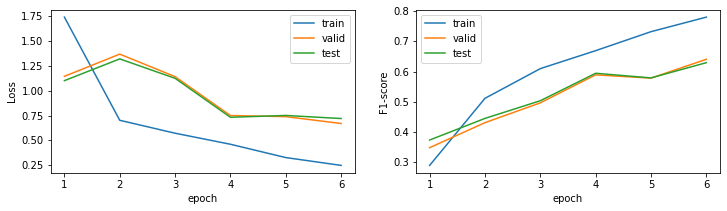

train 0 ?.npy file load 완료
epoch: 6	data num: 100	Loss: 0.175	f1_score: 0.866
train 1 ?.npy file load 완료
epoch: 6	data num: 200	Loss: 0.100	f1_score: 0.894
train 2 ?.npy file load 완료
epoch: 6	data num: 300	Loss: 0.180	f1_score: 0.836
train 3 ?.npy file load 완료
epoch: 6	data num: 400	Loss: 0.331	f1_score: 0.770
train 4 ?.npy file load 완료
epoch: 6	data num: 500	Loss: 0.165	f1_score: 0.842
train 5 ?.npy file load 완료
epoch: 6	data num: 600	Loss: 0.268	f1_score: 0.835
train 6 ?.npy file load 완료
epoch: 6	data num: 700	Loss: 0.389	f1_score: 0.677
train 7 ?.npy file load 완료
epoch: 6	data num: 800	Loss: 0.199	f1_score: 0.831
train 8 ?.npy file load 완료
epoch: 6	data num: 900	Loss: 0.188	f1_score: 0.816
train 9 ?.npy file load 완료
epoch: 6	data num: 1000	Loss: 0.243	f1_score: 0.788
train 10 ?.npy file load 완료
epoch: 6	data num: 1100	Loss: 0.164	f1_score: 0.808
train 11 ?.npy file load 완료
epoch: 6	data num: 1200	Loss: 0.304	f1_score: 0.733
train 12 ?.npy file load 완료
epoch: 6	data num: 1300	Loss: 0

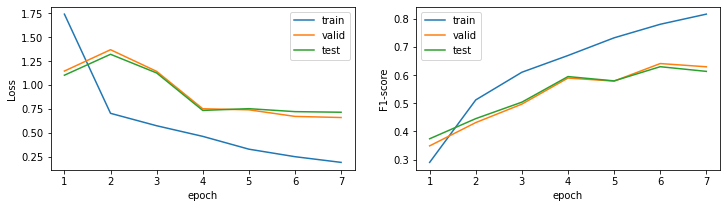

train 0 ?.npy file load 완료
epoch: 7	data num: 100	Loss: 0.192	f1_score: 0.869
train 1 ?.npy file load 완료
epoch: 7	data num: 200	Loss: 0.078	f1_score: 0.928
train 2 ?.npy file load 완료
epoch: 7	data num: 300	Loss: 0.077	f1_score: 0.917
train 3 ?.npy file load 완료
epoch: 7	data num: 400	Loss: 0.125	f1_score: 0.858
train 4 ?.npy file load 완료
epoch: 7	data num: 500	Loss: 0.159	f1_score: 0.863
train 5 ?.npy file load 완료
epoch: 7	data num: 600	Loss: 0.369	f1_score: 0.731
train 6 ?.npy file load 완료
epoch: 7	data num: 700	Loss: 0.150	f1_score: 0.800
train 7 ?.npy file load 완료
epoch: 7	data num: 800	Loss: 0.153	f1_score: 0.863
train 8 ?.npy file load 완료
epoch: 7	data num: 900	Loss: 0.105	f1_score: 0.888
train 9 ?.npy file load 완료
epoch: 7	data num: 1000	Loss: 0.101	f1_score: 0.862
train 10 ?.npy file load 완료
epoch: 7	data num: 1100	Loss: 0.162	f1_score: 0.747
train 11 ?.npy file load 완료
epoch: 7	data num: 1200	Loss: 0.166	f1_score: 0.796
train 12 ?.npy file load 완료
epoch: 7	data num: 1300	Loss: 0

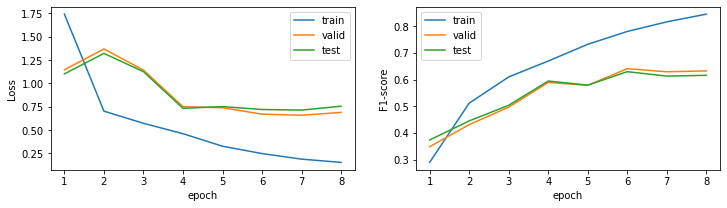

train 0 ?.npy file load 완료
epoch: 8	data num: 100	Loss: 0.101	f1_score: 0.913
train 1 ?.npy file load 완료
epoch: 8	data num: 200	Loss: 0.061	f1_score: 0.919
train 2 ?.npy file load 완료
epoch: 8	data num: 300	Loss: 0.094	f1_score: 0.906
train 3 ?.npy file load 완료
epoch: 8	data num: 400	Loss: 0.126	f1_score: 0.860
train 4 ?.npy file load 완료
epoch: 8	data num: 500	Loss: 0.220	f1_score: 0.856
train 5 ?.npy file load 완료
epoch: 8	data num: 600	Loss: 0.096	f1_score: 0.887
train 6 ?.npy file load 완료
epoch: 8	data num: 700	Loss: 0.177	f1_score: 0.819
train 7 ?.npy file load 완료
epoch: 8	data num: 800	Loss: 0.132	f1_score: 0.865
train 8 ?.npy file load 완료
epoch: 8	data num: 900	Loss: 0.110	f1_score: 0.881
train 9 ?.npy file load 완료
epoch: 8	data num: 1000	Loss: 0.134	f1_score: 0.835
train 10 ?.npy file load 완료
epoch: 8	data num: 1100	Loss: 0.118	f1_score: 0.849
train 11 ?.npy file load 완료
epoch: 8	data num: 1200	Loss: 0.169	f1_score: 0.822
train 12 ?.npy file load 완료
epoch: 8	data num: 1300	Loss: 0

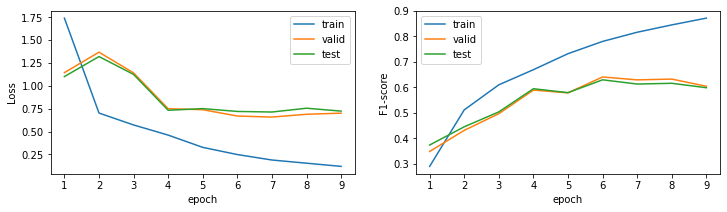

train 0 ?.npy file load 완료
epoch: 9	data num: 100	Loss: 0.160	f1_score: 0.866
train 1 ?.npy file load 완료
epoch: 9	data num: 200	Loss: 0.072	f1_score: 0.934
train 2 ?.npy file load 완료
epoch: 9	data num: 300	Loss: 0.071	f1_score: 0.924
train 3 ?.npy file load 완료
epoch: 9	data num: 400	Loss: 0.111	f1_score: 0.856
train 4 ?.npy file load 완료
epoch: 9	data num: 500	Loss: 0.150	f1_score: 0.876
train 5 ?.npy file load 완료
epoch: 9	data num: 600	Loss: 0.098	f1_score: 0.879
train 6 ?.npy file load 완료
epoch: 9	data num: 700	Loss: 0.124	f1_score: 0.840
train 7 ?.npy file load 완료
epoch: 9	data num: 800	Loss: 0.105	f1_score: 0.875
train 8 ?.npy file load 완료
epoch: 9	data num: 900	Loss: 0.060	f1_score: 0.919
train 9 ?.npy file load 완료
epoch: 9	data num: 1000	Loss: 0.083	f1_score: 0.897
train 10 ?.npy file load 완료
epoch: 9	data num: 1100	Loss: 0.131	f1_score: 0.808
train 11 ?.npy file load 완료
epoch: 9	data num: 1200	Loss: 0.168	f1_score: 0.827
train 12 ?.npy file load 완료
epoch: 9	data num: 1300	Loss: 0

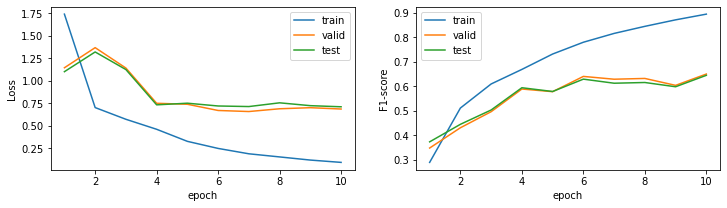

train 0 ?.npy file load 완료
epoch: 10	data num: 100	Loss: 0.071	f1_score: 0.938
train 1 ?.npy file load 완료
epoch: 10	data num: 200	Loss: 0.030	f1_score: 0.963
train 2 ?.npy file load 완료
epoch: 10	data num: 300	Loss: 0.098	f1_score: 0.921
train 3 ?.npy file load 완료
epoch: 10	data num: 400	Loss: 0.093	f1_score: 0.877
train 4 ?.npy file load 완료
epoch: 10	data num: 500	Loss: 0.089	f1_score: 0.914
train 5 ?.npy file load 완료
epoch: 10	data num: 600	Loss: 0.111	f1_score: 0.886
train 6 ?.npy file load 완료
epoch: 10	data num: 700	Loss: 0.126	f1_score: 0.831
train 7 ?.npy file load 완료
epoch: 10	data num: 800	Loss: 0.104	f1_score: 0.904
train 8 ?.npy file load 완료
epoch: 10	data num: 900	Loss: 0.068	f1_score: 0.911
train 9 ?.npy file load 완료
epoch: 10	data num: 1000	Loss: 0.064	f1_score: 0.917
train 10 ?.npy file load 완료
epoch: 10	data num: 1100	Loss: 0.107	f1_score: 0.839
train 11 ?.npy file load 완료
epoch: 10	data num: 1200	Loss: 0.065	f1_score: 0.918
train 12 ?.npy file load 완료
epoch: 10	data num:

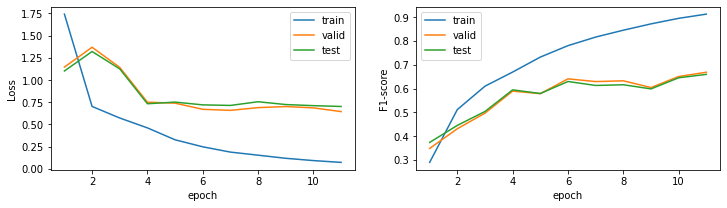

train 0 ?.npy file load 완료
epoch: 11	data num: 100	Loss: 0.058	f1_score: 0.945
train 1 ?.npy file load 완료
epoch: 11	data num: 200	Loss: 0.051	f1_score: 0.942
train 2 ?.npy file load 완료
epoch: 11	data num: 300	Loss: 0.044	f1_score: 0.945
train 3 ?.npy file load 완료
epoch: 11	data num: 400	Loss: 0.090	f1_score: 0.877
train 4 ?.npy file load 완료
epoch: 11	data num: 500	Loss: 0.058	f1_score: 0.933
train 5 ?.npy file load 완료
epoch: 11	data num: 600	Loss: 0.042	f1_score: 0.952
train 6 ?.npy file load 완료
epoch: 11	data num: 700	Loss: 0.074	f1_score: 0.887
train 7 ?.npy file load 완료
epoch: 11	data num: 800	Loss: 0.061	f1_score: 0.927
train 8 ?.npy file load 완료
epoch: 11	data num: 900	Loss: 0.049	f1_score: 0.934
train 9 ?.npy file load 완료
epoch: 11	data num: 1000	Loss: 0.043	f1_score: 0.924
train 10 ?.npy file load 완료
epoch: 11	data num: 1100	Loss: 0.094	f1_score: 0.856
train 11 ?.npy file load 완료
epoch: 11	data num: 1200	Loss: 0.081	f1_score: 0.908
train 12 ?.npy file load 완료
epoch: 11	data num:

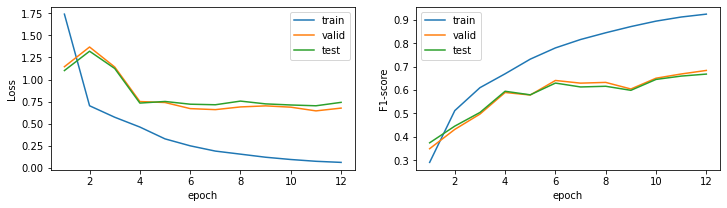

train 0 ?.npy file load 완료
epoch: 12	data num: 100	Loss: 0.053	f1_score: 0.948
train 1 ?.npy file load 완료
epoch: 12	data num: 200	Loss: 0.064	f1_score: 0.936
train 2 ?.npy file load 완료
epoch: 12	data num: 300	Loss: 0.044	f1_score: 0.947
train 3 ?.npy file load 완료
epoch: 12	data num: 400	Loss: 0.062	f1_score: 0.900
train 4 ?.npy file load 완료
epoch: 12	data num: 500	Loss: 0.063	f1_score: 0.939
train 5 ?.npy file load 완료
epoch: 12	data num: 600	Loss: 0.059	f1_score: 0.929
train 6 ?.npy file load 완료
epoch: 12	data num: 700	Loss: 0.068	f1_score: 0.904
train 7 ?.npy file load 완료
epoch: 12	data num: 800	Loss: 0.040	f1_score: 0.958
train 8 ?.npy file load 완료
epoch: 12	data num: 900	Loss: 0.071	f1_score: 0.921
train 9 ?.npy file load 완료
epoch: 12	data num: 1000	Loss: 0.065	f1_score: 0.920
train 10 ?.npy file load 완료
epoch: 12	data num: 1100	Loss: 0.072	f1_score: 0.892
train 11 ?.npy file load 완료
epoch: 12	data num: 1200	Loss: 0.066	f1_score: 0.899
train 12 ?.npy file load 완료
epoch: 12	data num:

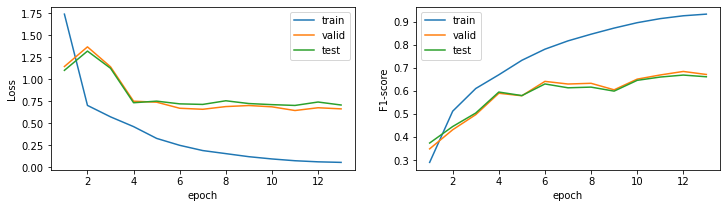

train 0 ?.npy file load 완료
epoch: 13	data num: 100	Loss: 0.043	f1_score: 0.956
train 1 ?.npy file load 완료
epoch: 13	data num: 200	Loss: 0.043	f1_score: 0.954
train 2 ?.npy file load 완료
epoch: 13	data num: 300	Loss: 0.050	f1_score: 0.941
train 3 ?.npy file load 완료
epoch: 13	data num: 400	Loss: 0.043	f1_score: 0.939
train 4 ?.npy file load 완료
epoch: 13	data num: 500	Loss: 0.046	f1_score: 0.957
train 5 ?.npy file load 완료
epoch: 13	data num: 600	Loss: 0.051	f1_score: 0.948
train 6 ?.npy file load 완료
epoch: 13	data num: 700	Loss: 0.059	f1_score: 0.919
train 7 ?.npy file load 완료
epoch: 13	data num: 800	Loss: 0.034	f1_score: 0.956
train 8 ?.npy file load 완료
epoch: 13	data num: 900	Loss: 0.027	f1_score: 0.965
train 9 ?.npy file load 완료
epoch: 13	data num: 1000	Loss: 0.053	f1_score: 0.936
train 10 ?.npy file load 완료
epoch: 13	data num: 1100	Loss: 0.066	f1_score: 0.899
train 11 ?.npy file load 완료
epoch: 13	data num: 1200	Loss: 0.043	f1_score: 0.937
train 12 ?.npy file load 완료
epoch: 13	data num:

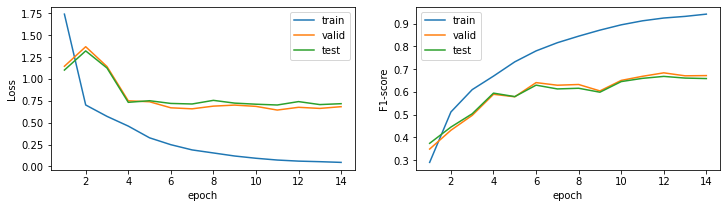

train 0 ?.npy file load 완료
epoch: 14	data num: 100	Loss: 0.032	f1_score: 0.959
train 1 ?.npy file load 완료
epoch: 14	data num: 200	Loss: 0.034	f1_score: 0.955
train 2 ?.npy file load 완료
epoch: 14	data num: 300	Loss: 0.032	f1_score: 0.967
train 3 ?.npy file load 완료
epoch: 14	data num: 400	Loss: 0.065	f1_score: 0.923
train 4 ?.npy file load 완료
epoch: 14	data num: 500	Loss: 0.070	f1_score: 0.935
train 5 ?.npy file load 완료
epoch: 14	data num: 600	Loss: 0.019	f1_score: 0.976
train 6 ?.npy file load 완료
epoch: 14	data num: 700	Loss: 0.046	f1_score: 0.919
train 7 ?.npy file load 완료
epoch: 14	data num: 800	Loss: 0.049	f1_score: 0.946
train 8 ?.npy file load 완료
epoch: 14	data num: 900	Loss: 0.022	f1_score: 0.965
train 9 ?.npy file load 완료
epoch: 14	data num: 1000	Loss: 0.024	f1_score: 0.954
train 10 ?.npy file load 완료
epoch: 14	data num: 1100	Loss: 0.063	f1_score: 0.941
train 11 ?.npy file load 완료
epoch: 14	data num: 1200	Loss: 0.052	f1_score: 0.924
train 12 ?.npy file load 완료
epoch: 14	data num:

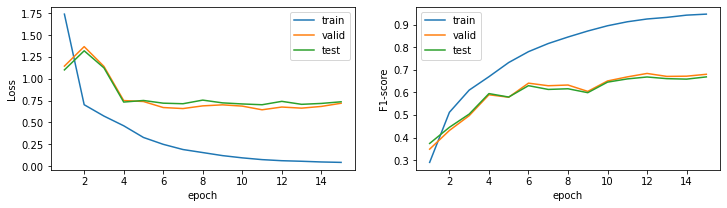

train 0 ?.npy file load 완료
epoch: 15	data num: 100	Loss: 0.044	f1_score: 0.951
train 1 ?.npy file load 완료
epoch: 15	data num: 200	Loss: 0.032	f1_score: 0.964
train 2 ?.npy file load 완료
epoch: 15	data num: 300	Loss: 0.018	f1_score: 0.979
train 3 ?.npy file load 완료
epoch: 15	data num: 400	Loss: 0.066	f1_score: 0.913
train 4 ?.npy file load 완료
epoch: 15	data num: 500	Loss: 0.070	f1_score: 0.939
train 5 ?.npy file load 완료
epoch: 15	data num: 600	Loss: 0.038	f1_score: 0.950
train 6 ?.npy file load 완료
epoch: 15	data num: 700	Loss: 0.108	f1_score: 0.898
train 7 ?.npy file load 완료
epoch: 15	data num: 800	Loss: 0.060	f1_score: 0.947
train 8 ?.npy file load 완료
epoch: 15	data num: 900	Loss: 0.054	f1_score: 0.942
train 9 ?.npy file load 완료
epoch: 15	data num: 1000	Loss: 0.042	f1_score: 0.955
train 10 ?.npy file load 완료
epoch: 15	data num: 1100	Loss: 0.054	f1_score: 0.937
train 11 ?.npy file load 완료
epoch: 15	data num: 1200	Loss: 0.047	f1_score: 0.930
train 12 ?.npy file load 완료
epoch: 15	data num:

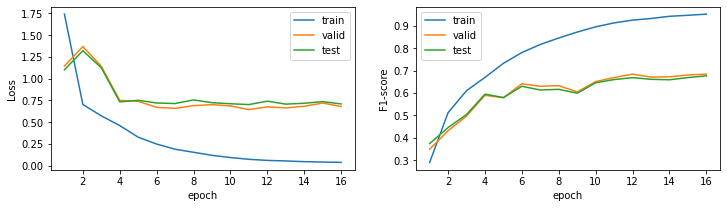

train 0 ?.npy file load 완료
epoch: 16	data num: 100	Loss: 0.028	f1_score: 0.974
train 1 ?.npy file load 완료
epoch: 16	data num: 200	Loss: 0.017	f1_score: 0.970
train 2 ?.npy file load 완료
epoch: 16	data num: 300	Loss: 0.047	f1_score: 0.962
train 3 ?.npy file load 완료
epoch: 16	data num: 400	Loss: 0.041	f1_score: 0.935
train 4 ?.npy file load 완료
epoch: 16	data num: 500	Loss: 0.035	f1_score: 0.952
train 5 ?.npy file load 완료
epoch: 16	data num: 600	Loss: 0.049	f1_score: 0.945
train 6 ?.npy file load 완료
epoch: 16	data num: 700	Loss: 0.074	f1_score: 0.901
train 7 ?.npy file load 완료
epoch: 16	data num: 800	Loss: 0.038	f1_score: 0.958
train 8 ?.npy file load 완료
epoch: 16	data num: 900	Loss: 0.025	f1_score: 0.967
train 9 ?.npy file load 완료
epoch: 16	data num: 1000	Loss: 0.023	f1_score: 0.957
train 10 ?.npy file load 완료
epoch: 16	data num: 1100	Loss: 0.212	f1_score: 0.780
train 11 ?.npy file load 완료
epoch: 16	data num: 1200	Loss: 0.419	f1_score: 0.598
train 12 ?.npy file load 완료
epoch: 16	data num:

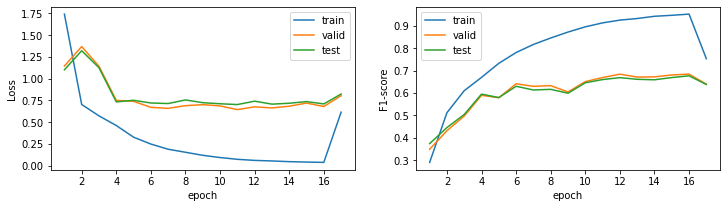

train 0 ?.npy file load 완료
epoch: 17	data num: 100	Loss: 0.185	f1_score: 0.857
train 1 ?.npy file load 완료
epoch: 17	data num: 200	Loss: 0.178	f1_score: 0.871
train 2 ?.npy file load 완료
epoch: 17	data num: 300	Loss: 0.281	f1_score: 0.806
train 3 ?.npy file load 완료
epoch: 17	data num: 400	Loss: 0.302	f1_score: 0.700
train 4 ?.npy file load 완료
epoch: 17	data num: 500	Loss: 0.245	f1_score: 0.749
train 5 ?.npy file load 완료
epoch: 17	data num: 600	Loss: 0.288	f1_score: 0.796
train 6 ?.npy file load 완료
epoch: 17	data num: 700	Loss: 0.302	f1_score: 0.746
train 7 ?.npy file load 완료
epoch: 17	data num: 800	Loss: 0.371	f1_score: 0.780
train 8 ?.npy file load 완료
epoch: 17	data num: 900	Loss: 0.128	f1_score: 0.870
train 9 ?.npy file load 완료
epoch: 17	data num: 1000	Loss: 0.368	f1_score: 0.782
train 10 ?.npy file load 완료
epoch: 17	data num: 1100	Loss: 0.808	f1_score: 0.522
train 11 ?.npy file load 완료
epoch: 17	data num: 1200	Loss: 0.479	f1_score: 0.680
train 12 ?.npy file load 완료
epoch: 17	data num:

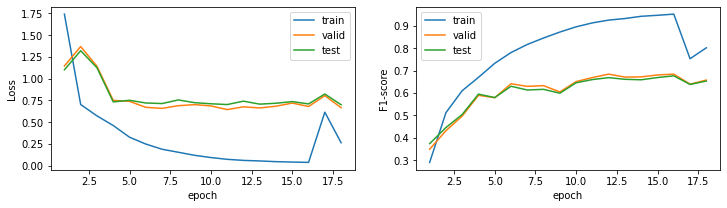

train 0 ?.npy file load 완료
epoch: 18	data num: 100	Loss: 0.109	f1_score: 0.921
train 1 ?.npy file load 완료
epoch: 18	data num: 200	Loss: 0.094	f1_score: 0.911
train 2 ?.npy file load 완료
epoch: 18	data num: 300	Loss: 0.074	f1_score: 0.900
train 3 ?.npy file load 완료
epoch: 18	data num: 400	Loss: 0.236	f1_score: 0.768
train 4 ?.npy file load 완료
epoch: 18	data num: 500	Loss: 0.221	f1_score: 0.826
train 5 ?.npy file load 완료
epoch: 18	data num: 600	Loss: 0.323	f1_score: 0.856
train 6 ?.npy file load 완료
epoch: 18	data num: 700	Loss: 0.164	f1_score: 0.808
train 7 ?.npy file load 완료
epoch: 18	data num: 800	Loss: 0.115	f1_score: 0.887
train 8 ?.npy file load 완료
epoch: 18	data num: 900	Loss: 0.120	f1_score: 0.889
train 9 ?.npy file load 완료
epoch: 18	data num: 1000	Loss: 0.145	f1_score: 0.851
train 10 ?.npy file load 완료
epoch: 18	data num: 1100	Loss: 0.269	f1_score: 0.776
train 11 ?.npy file load 완료
epoch: 18	data num: 1200	Loss: 0.122	f1_score: 0.844
train 12 ?.npy file load 완료
epoch: 18	data num:

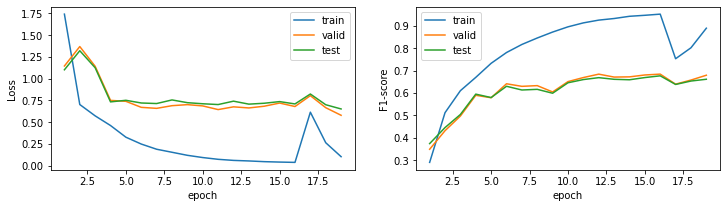

train 0 ?.npy file load 완료
epoch: 19	data num: 100	Loss: 0.098	f1_score: 0.922
train 1 ?.npy file load 완료
epoch: 19	data num: 200	Loss: 0.033	f1_score: 0.957
train 2 ?.npy file load 완료
epoch: 19	data num: 300	Loss: 0.042	f1_score: 0.945
train 3 ?.npy file load 완료
epoch: 19	data num: 400	Loss: 0.062	f1_score: 0.911
train 4 ?.npy file load 완료
epoch: 19	data num: 500	Loss: 0.148	f1_score: 0.907
train 5 ?.npy file load 완료
epoch: 19	data num: 600	Loss: 0.045	f1_score: 0.954
train 6 ?.npy file load 완료
epoch: 19	data num: 700	Loss: 0.086	f1_score: 0.874
train 7 ?.npy file load 완료
epoch: 19	data num: 800	Loss: 0.074	f1_score: 0.912
train 8 ?.npy file load 완료
epoch: 19	data num: 900	Loss: 0.045	f1_score: 0.952
train 9 ?.npy file load 완료
epoch: 19	data num: 1000	Loss: 0.081	f1_score: 0.897
train 10 ?.npy file load 완료
epoch: 19	data num: 1100	Loss: 0.077	f1_score: 0.886
train 11 ?.npy file load 완료
epoch: 19	data num: 1200	Loss: 0.092	f1_score: 0.864
train 12 ?.npy file load 완료
epoch: 19	data num:

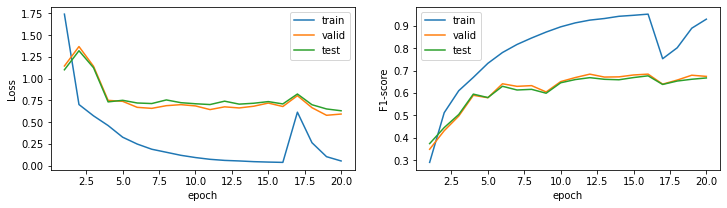

train 0 ?.npy file load 완료
epoch: 20	data num: 100	Loss: 0.050	f1_score: 0.958
train 1 ?.npy file load 완료
epoch: 20	data num: 200	Loss: 0.033	f1_score: 0.950
train 2 ?.npy file load 완료
epoch: 20	data num: 300	Loss: 0.023	f1_score: 0.966
train 3 ?.npy file load 완료
epoch: 20	data num: 400	Loss: 0.064	f1_score: 0.934
train 4 ?.npy file load 완료
epoch: 20	data num: 500	Loss: 0.060	f1_score: 0.921
train 5 ?.npy file load 완료
epoch: 20	data num: 600	Loss: 0.030	f1_score: 0.950
train 6 ?.npy file load 완료
epoch: 20	data num: 700	Loss: 0.038	f1_score: 0.928
train 7 ?.npy file load 완료
epoch: 20	data num: 800	Loss: 0.034	f1_score: 0.949
train 8 ?.npy file load 완료
epoch: 20	data num: 900	Loss: 0.021	f1_score: 0.965
train 9 ?.npy file load 완료
epoch: 20	data num: 1000	Loss: 0.026	f1_score: 0.956
train 10 ?.npy file load 완료
epoch: 20	data num: 1100	Loss: 0.026	f1_score: 0.934
train 11 ?.npy file load 완료
epoch: 20	data num: 1200	Loss: 0.063	f1_score: 0.904
train 12 ?.npy file load 완료
epoch: 20	data num:

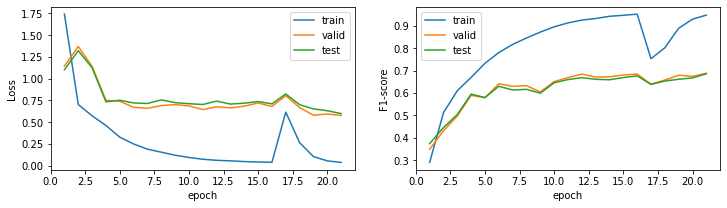

train 0 ?.npy file load 완료
epoch: 21	data num: 100	Loss: 0.033	f1_score: 0.968
train 1 ?.npy file load 완료
epoch: 21	data num: 200	Loss: 0.036	f1_score: 0.966
train 2 ?.npy file load 완료
epoch: 21	data num: 300	Loss: 0.028	f1_score: 0.962
train 3 ?.npy file load 완료
epoch: 21	data num: 400	Loss: 0.025	f1_score: 0.956
train 4 ?.npy file load 완료
epoch: 21	data num: 500	Loss: 0.014	f1_score: 0.975
train 5 ?.npy file load 완료
epoch: 21	data num: 600	Loss: 0.025	f1_score: 0.974
train 6 ?.npy file load 완료
epoch: 21	data num: 700	Loss: 0.041	f1_score: 0.912
train 7 ?.npy file load 완료
epoch: 21	data num: 800	Loss: 0.046	f1_score: 0.944
train 8 ?.npy file load 완료
epoch: 21	data num: 900	Loss: 0.025	f1_score: 0.970
train 9 ?.npy file load 완료
epoch: 21	data num: 1000	Loss: 0.018	f1_score: 0.971
train 10 ?.npy file load 완료
epoch: 21	data num: 1100	Loss: 0.056	f1_score: 0.881
train 11 ?.npy file load 완료
epoch: 21	data num: 1200	Loss: 0.034	f1_score: 0.950
train 12 ?.npy file load 완료
epoch: 21	data num:

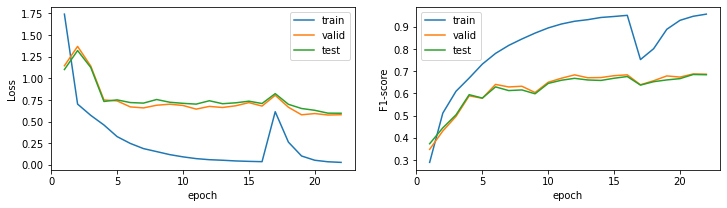

train 0 ?.npy file load 완료
epoch: 22	data num: 100	Loss: 0.052	f1_score: 0.955
train 1 ?.npy file load 완료
epoch: 22	data num: 200	Loss: 0.023	f1_score: 0.972
train 2 ?.npy file load 완료
epoch: 22	data num: 300	Loss: 0.020	f1_score: 0.974
train 3 ?.npy file load 완료
epoch: 22	data num: 400	Loss: 0.036	f1_score: 0.954
train 4 ?.npy file load 완료
epoch: 22	data num: 500	Loss: 0.020	f1_score: 0.956
train 5 ?.npy file load 완료
epoch: 22	data num: 600	Loss: 0.005	f1_score: 0.992
train 6 ?.npy file load 완료
epoch: 22	data num: 700	Loss: 0.037	f1_score: 0.940
train 7 ?.npy file load 완료
epoch: 22	data num: 800	Loss: 0.022	f1_score: 0.968
train 8 ?.npy file load 완료
epoch: 22	data num: 900	Loss: 0.025	f1_score: 0.965
train 9 ?.npy file load 완료
epoch: 22	data num: 1000	Loss: 0.032	f1_score: 0.961
train 10 ?.npy file load 완료
epoch: 22	data num: 1100	Loss: 0.026	f1_score: 0.947
train 11 ?.npy file load 완료
epoch: 22	data num: 1200	Loss: 0.025	f1_score: 0.961
train 12 ?.npy file load 완료
epoch: 22	data num:

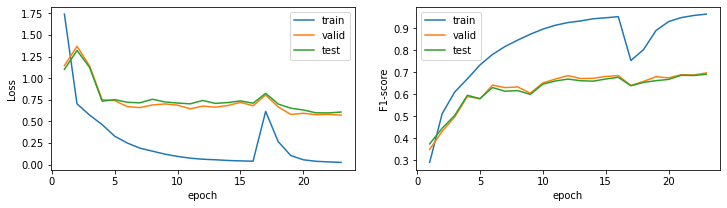

train 0 ?.npy file load 완료
epoch: 23	data num: 100	Loss: 0.016	f1_score: 0.980
train 1 ?.npy file load 완료
epoch: 23	data num: 200	Loss: 0.025	f1_score: 0.974
train 2 ?.npy file load 완료
epoch: 23	data num: 300	Loss: 0.010	f1_score: 0.981
train 3 ?.npy file load 완료
epoch: 23	data num: 400	Loss: 0.028	f1_score: 0.959
train 4 ?.npy file load 완료
epoch: 23	data num: 500	Loss: 0.028	f1_score: 0.956
train 5 ?.npy file load 완료
epoch: 23	data num: 600	Loss: 0.019	f1_score: 0.978
train 6 ?.npy file load 완료
epoch: 23	data num: 700	Loss: 0.052	f1_score: 0.923
train 7 ?.npy file load 완료
epoch: 23	data num: 800	Loss: 0.013	f1_score: 0.981
train 8 ?.npy file load 완료
epoch: 23	data num: 900	Loss: 0.016	f1_score: 0.976
train 9 ?.npy file load 완료
epoch: 23	data num: 1000	Loss: 0.014	f1_score: 0.978
train 10 ?.npy file load 완료
epoch: 23	data num: 1100	Loss: 0.043	f1_score: 0.943
train 11 ?.npy file load 완료
epoch: 23	data num: 1200	Loss: 0.038	f1_score: 0.940
train 12 ?.npy file load 완료
epoch: 23	data num:

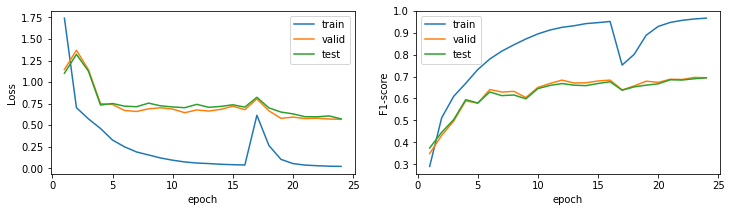

train 0 ?.npy file load 완료
epoch: 24	data num: 100	Loss: 0.025	f1_score: 0.974
train 1 ?.npy file load 완료
epoch: 24	data num: 200	Loss: 0.028	f1_score: 0.960
train 2 ?.npy file load 완료
epoch: 24	data num: 300	Loss: 0.017	f1_score: 0.979
train 3 ?.npy file load 완료
epoch: 24	data num: 400	Loss: 0.012	f1_score: 0.977
train 4 ?.npy file load 완료
epoch: 24	data num: 500	Loss: 0.019	f1_score: 0.965
train 5 ?.npy file load 완료
epoch: 24	data num: 600	Loss: 0.024	f1_score: 0.976
train 6 ?.npy file load 완료
epoch: 24	data num: 700	Loss: 0.025	f1_score: 0.960
train 7 ?.npy file load 완료
epoch: 24	data num: 800	Loss: 0.011	f1_score: 0.979
train 8 ?.npy file load 완료
epoch: 24	data num: 900	Loss: 0.028	f1_score: 0.967
train 9 ?.npy file load 완료
epoch: 24	data num: 1000	Loss: 0.009	f1_score: 0.982
train 10 ?.npy file load 완료
epoch: 24	data num: 1100	Loss: 0.028	f1_score: 0.961
train 11 ?.npy file load 완료
epoch: 24	data num: 1200	Loss: 0.021	f1_score: 0.969
train 12 ?.npy file load 완료
epoch: 24	data num:

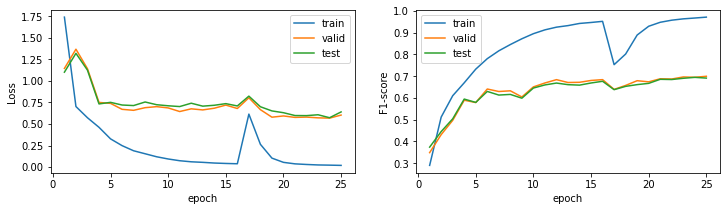

result.npy 저장 완료
모델 저장중....


In [ ]:
# 통일성 있게 코드 짜자.
train_epoch_loss = []
train_epoch_acc = []
valid_epoch_loss = []
valid_epoch_acc = []
test_epoch_loss = []
test_epoch_acc = []

batch_size = 10
epochs = 25
print_interval = 10

for epoch in range(epochs):

    ''' Train '''
    model.train()
    train_batch_loss = []
    train_batch_acc = []
   
    train_npy_file = 40
    each_npy_file = 100
    train_batch_num = train_npy_file*each_npy_file/batch_size

    for train_idx in range(train_npy_file):
        root = "./KWS_data/XY_train/train"
        X_train = torch.Tensor(np.load(root + str(train_idx)+"_X.npy")) #(100, 1723, 24)
        Y_train = torch.Tensor(np.load(root + str(train_idx)+"_Y.npy")) #(100, 1723, 1)

        print("train", train_idx, "?.npy file load 완료")
        for batch_idx in range(int(each_npy_file/batch_size)):
            
            mini_batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            mini_batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.float()).to(device)

            optimizer.zero_grad()
            output = model(x).squeeze() # (100, 1723, 1)->(100, 1723)
            target = target.squeeze() 

            loss = nn.BCEWithLogitsLoss()(output, target).to(device)

            loss.backward()    # calc gradients
            train_batch_loss.append(loss.item()) # /batch_size*100
            optimizer.step()   # update gradients
            
            # Accuracy computation
            predicted = (output > 0.6).float().cpu().numpy()
            target = target.cpu().numpy()
            #accuracy = (predicted == target).float().mean().item()/batch_size*100  # sum?
            f1_acc_micro = f1_score(target, predicted, average='micro')
            #f1_acc_macro = f1_score(target, predicted, average='macro')
            train_batch_acc.append(f1_acc_micro)
        # data 100개마다 출력해보기
        print('epoch: {}\tdata num: {}\tLoss: {:.3f}\tf1_score: {:.3f}'.format(
        epoch, (train_idx+1)*100, train_batch_loss[-1], train_batch_acc[-1]))

    # 1 epoch 종료
    train_epoch_loss.append(np.sum(train_batch_loss)/train_batch_num)
    train_epoch_acc.append(np.sum(train_batch_acc)/train_batch_num)

    ''' valid '''
    print("====valid====")
    model.eval()
    valid_batch_loss = []
    valid_batch_acc = []
   
    valid_npy_file = 8
    each_npy_file = 100
    valid_batch_num = valid_npy_file*each_npy_file/batch_size

    for valid_idx in range(train_npy_file, train_npy_file + valid_npy_file):
        root = "./KWS_data/XY_train/train"
        X_valid = torch.Tensor(np.load(root + str(valid_idx)+"_X.npy")) #(100, 1723, 24)
        Y_valid = torch.Tensor(np.load(root + str(valid_idx)+"_Y.npy")) #(100, 1723, 1)

        print("valid", valid_idx, "?.npy file load 완료")
        for batch_idx in range(int(each_npy_file/batch_size)):
            
            mini_batch_x = X_valid[batch_idx*batch_size:(batch_idx+1)*batch_size]
            mini_batch_y = Y_valid[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.float()).to(device)

            optimizer.zero_grad()
            output = model(x).squeeze() # (100, 1723, 1)->(100, 1723)
            target = target.squeeze() 

            loss = nn.BCEWithLogitsLoss()(output, target).to(device)
            valid_batch_loss.append(loss.item()) # /batch_size*100
            
            # Accuracy computation
            predicted = (output > 0.6).float().cpu().numpy()
            target = target.cpu().numpy()
            #accuracy = (predicted == target).float().mean().item()/batch_size*100  # sum?
            f1_acc_micro = f1_score(target, predicted, average='micro')
            #f1_acc_macro = f1_score(target, predicted, average='macro')
            valid_batch_acc.append(f1_acc_micro)
        # data 100개마다 출력해보기
        print('epoch: {}\tdata num: {}\tLoss: {:.3f}\tf1_score: {:.3f}'.format(
        epoch, (valid_idx+1)*100, valid_batch_loss[-1], valid_batch_acc[-1]))

    # 1 epoch 종료
    valid_epoch_loss.append(np.sum(valid_batch_loss)/valid_batch_num)
    valid_epoch_acc.append(np.sum(valid_batch_acc)/valid_batch_num)

    ''' test '''
    print("====test====")
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
   
    test_npy_file = 2
    each_npy_file = 100
    test_batch_num = test_npy_file*each_npy_file/batch_size
    test_start = train_npy_file + valid_npy_file
    for test_idx in range(test_start, test_start + test_npy_file):
        root = "./KWS_data/XY_train/train"
        X_test = torch.Tensor(np.load(root + str(test_idx) +"_X.npy")) #(100, 1723, 24)
        Y_test = torch.Tensor(np.load(root + str(test_idx) + "_Y.npy")) #(100, 1723, 1)

        print("test", test_idx, "?.npy file load 완료")
        for batch_idx in range(int(each_npy_file/batch_size)):
            
            mini_batch_x = X_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
            mini_batch_y = Y_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.float()).to(device)

            optimizer.zero_grad()
            output = model(x).squeeze() # (100, 1723, 1)->(100, 1723)
            target = target.squeeze() 

            loss = nn.BCEWithLogitsLoss()(output, target).to(device)

            test_batch_loss.append(loss.item()) # /batch_size*100

            
            # Accuracy computation
            predicted = (output > 0.6).float().cpu().numpy()
            target = target.cpu().numpy()
            #accuracy = (predicted == target).float().mean().item()/batch_size*100  # sum?
            f1_acc_micro = f1_score(target, predicted, average='micro')
            #f1_acc_macro = f1_score(target, predicted, average='macro')
            test_batch_acc.append(f1_acc_micro)
        # data 100개마다 출력해보기
        print('epoch: {}\tdata num: {}\tLoss: {:.3f}\tf1_score: {:.3f}'.format(
        epoch, (test_idx+1)*100, test_batch_loss[-1], test_batch_acc[-1]))

    # 1 epoch 종료
    test_epoch_loss.append(np.sum(test_batch_loss)/test_batch_num)
    test_epoch_acc.append(np.sum(test_batch_acc)/test_batch_num)


    ############### 중간 plot & 모델 저장
    x_axis = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(x_axis, train_epoch_loss, label='train')
    plt.plot(x_axis, valid_epoch_loss, label='valid')
    plt.plot(x_axis, test_epoch_loss, label='test')
    ax1.legend()
    ax1.set(ylabel="Loss", xlabel='epoch')

    ax2 = fig.add_subplot(1, 2, 2)
    plt.plot(x_axis, train_epoch_acc, label='train')
    plt.plot(x_axis, valid_epoch_acc, label='valid')
    plt.plot(x_axis, test_epoch_acc, label='test')
    ax2.legend()
    ax2.set(ylabel="F1-score", xlabel='epoch')

    plt.show()


# Train 끝
test_final_acc = "train_{:.3f}_test_{:.3f}".format(train_epoch_acc[-1],
                                           test_epoch_acc[-1])
experience_path = "./실험_cv/" + test_final_acc
os.makedirs(experience_path, exist_ok=True)
train_test_result = (train_epoch_loss, valid_epoch_loss,test_epoch_loss, 
                     train_epoch_acc, test_epoch_acc, valid_epoch_acc)
np.save(experience_path+"/result.npy", train_test_result)

f = open(experience_path+"/train_spec.txt", 'w')
drop_prob1 = 0
f.write("epoch:{}, GRU: 2 layer,lr:{}, drop_prob2:{}, weight_decay={}\n".format(
    epochs, lr, drop_prob, weight_decay
))
f.write("F1-Score\n=====================\n")
f.write("Train:{:.3f}, Valid:{:.3f}, Test:{:.3f}".format(
        train_epoch_acc[-1], valid_epoch_acc[-1], test_epoch_acc[-1]))
f.close()

print("result.npy 저장 완료")

# ''' inference를 위한 모델 저장  '''
print("모델 저장중....")
model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./GRU_2layer_cv"
option = 2

model = model.cpu()

if option == 0:
    model_path = model_name + '_all.pt'
    torch.save(model, model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    torch.save(model.state_dict, model_path)

elif option == 2:
    model_path = model_name + '_ckp.tar'
    torch.save({
            'last_epoch': epochs -1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_path)
################ 중간 plot & 모델 저장

    

result.npy 저장 완료


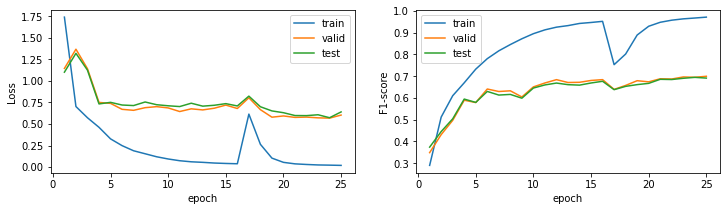

In [ ]:
# Train 끝
test_final_acc = "train_{:.3f}_test_{:.3f}".format(train_epoch_acc[-1],
                                           test_epoch_acc[-1])
experience_path = "./실험_cv/" + test_final_acc
os.makedirs(experience_path, exist_ok=True)
train_test_result = (train_epoch_loss, valid_epoch_loss,test_epoch_loss, 
                     train_epoch_acc, test_epoch_acc, valid_epoch_acc)
np.save(experience_path+"/result.npy", train_test_result)

f = open(experience_path+"/train_spec.txt", 'w')
drop_prob1 = 0
f.write("epoch:{}, GRU: 2 layer,lr:{}, drop_prob2:{}, weight_decay={}\n".format(
    epochs, lr, drop_prob, weight_decay
))
f.write("F1-Score\n=====================\n")
f.write("Train:{:.3f}, Valid:{:.3f}, Test:{:.3f}".format(
        train_epoch_acc[-1], valid_epoch_acc[-1], test_epoch_acc[-1]))
f.close()

print("result.npy 저장 완료")

fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(x_axis, train_epoch_loss, label='train')
plt.plot(x_axis, valid_epoch_loss, label='valid')
plt.plot(x_axis, test_epoch_loss, label='test')
ax1.legend()
ax1.set(ylabel="Loss", xlabel='epoch')

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(x_axis, train_epoch_acc, label='train')
plt.plot(x_axis, valid_epoch_acc, label='valid')
plt.plot(x_axis, test_epoch_acc, label='test')
ax2.legend()
ax2.set(ylabel="F1-score", xlabel='epoch')
plt.savefig(experience_path+"/loss & F1-score.png")

In [ ]:
''' inference를 위한 모델 저장  '''  # 대박 한 2분 걸림...
model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./GRU_2layer_절약"
option = 2

if option == 0:
    model_path = model_name + '_all.pt'
    torch.save(model, model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    torch.save(model.state_dict, model_path)

elif option == 2:
    model_path = model_name + '_ckp.tar'
    torch.save({
            #'last_epoch': epochs -1,
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_path)

KeyboardInterrupt: ignored

## After KWS training

In [ ]:

''' 모델 불러오기 '''

model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./GRU_2layer_절약"
option = 2

device = torch.device('cpu')

if option == 0:
    # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
    model_path = model_name + '_all.pt'
    model = torch.load(model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    model = CNN_Net()
    model.load_state_dict(torch.load(model_path))

elif option == 2:
    # model, optimizer 초기화
    model = KWS_2GRU()  #.to(device)
    #optimizer = optim.Adam(model.parameters()) #, weight_decay=weight_decay)  lr=lr

    model_path = model_name + '_ckp.tar'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #last_epoch = checkpoint['last_epoch']
    #loss = checkpoint['loss']

In [ ]:
pip install pydub

In [ ]:
import IPython.display as ipd
import librosa
from pydub import AudioSegment

In [ ]:
def feature_mfcc(RECORD_FILE_NAME):

    # 조정할 수 있는 건 다 적어보자.
    hop_length= 128
    n_mfcc = 24
    # n_mels = 20
    n_fft = 101
    fmin = 0
    fmax = None
    # sr = 16000

    # sr = 22050 = bitrate/2 -> Q. bitrate 와 어떤 관계?
    # Generate mfccs from a time series
    # t초당 sig.shape = (t*sr,)
    sig, sr = librosa.load(RECORD_FILE_NAME)  # , sr=sr

    # 만약, sr=16000, mfcc.shape = (n_mfcc,1251)
    #       sr=(default)22050, mfcc.shape = (n_mfcc, 1723)


    mfcc = librosa.feature.mfcc(y=sig, sr=sr, hop_length=hop_length, fmin=fmin, fmax = fmax,
                                  n_fft= n_fft, n_mfcc=n_mfcc)
    print("here", mfcc.shape)

    return mfcc

In [ ]:
RECORD_FILE_PATH = './10s_one_stop_two.wav' # 10s_one_stop_two.wav  # 10s_stop_one.wav
ipd.Audio(RECORD_FILE_PATH)

In [ ]:
mfcc = feature_mfcc(RECORD_FILE_PATH)  # [n_mfcc, Tx]
mfcc = np.transpose(mfcc)# [Tx, n_mfcc]
mfcc = np.expand_dims(mfcc, 0)  #[1, Tx, n_mfcc]
mfcc = torch.Tensor(mfcc).to(device)
prediction = model(mfcc).squeeze()
print(prediction.shape)

result = prediction.detach().cpu().numpy()
sig_result = torch.sigmoid(prediction).detach().cpu().numpy()
#print(result)
plt.plot(result)
plt.figure()
plt.plot(sig_result)

In [ ]:

peak_y = np.max(result)
peak_x = np.where(result == peak_y)[0][0]

# get Extraction duration
T_y = 1723
mark_length = 300  # 172로 하면, Tight 하긴한데 피아노 배경 Activate 말고 학습 굿
left_step = int(mark_length * 0.3)
left_x = peak_x - left_step if peak_x - left_step > 0 else 0
right_x = left_x + mark_length

scatter_x = [peak_x]  # , peak_x, left_x, right_x
scatter_y = [peak_y]  # , 0, 0, 0
plt.figure()
#plt.ylim([0, 1.1])
plt.plot(result)
plt.scatter(scatter_x, scatter_y, c=['r'])  # , 'r', 'g', 'g'
plt.axvline(x=left_x, color='r', linestyle='-')
plt.axvline(x=right_x, color='r', linestyle='-')
plt.show()

# pyaudio peak and restore
# pydub does thing in milliseconds
segment_left_t = int(left_x * 10000.0 / T_y)  # + 2500
segment_right_t = int(right_x * 10000.0 / T_y)  # + 2500


print("time: ", segment_left_t, "~", segment_right_t)

sig = AudioSegment.from_wav(RECORD_FILE_PATH)

ex_Keyword = sig[segment_left_t : segment_right_t + 1]

ex_FILE_PATH = "./extraction.wav"
file_handle = ex_Keyword.export(ex_FILE_PATH, format="wav")


In [ ]:
import librosa.display

In [ ]:
sig, sr = librosa.load(RECORD_FILE_PATH)
#librosa.display.waveplot(sig, sr=sr)
Time = np.linspace(0, len(sig) / sr, num=len(sig))
plt.plot(Time, sig)
#plt.scatter(scatter_x, scatter_y, c=['r'])  # , 'r', 'g', 'g'
plt.axvline(x=segment_left_t/1000, color='r', linestyle='-')
plt.axvline(x=segment_right_t/1000, color='r', linestyle='-')
plt.show()

In [ ]:
ipd.Audio(ex_FILE_PATH)